<a href="https://colab.research.google.com/github/jah1994/PyTorchDIA/blob/master/PyTorch_DIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# make sure to enable GPU acceleration!
device = 'cuda'

In [0]:
import torch
import numpy as np
from astropy.io.fits import getdata
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv

crop = 10
ks = 31
pw = 15

def convert_to_tensor(data):
    data = data.astype(np.float32)
    data = np.array([[data]])
    tensor = torch.from_numpy(data)
    return tensor

def infer_kernel(R, I, maxiter):
    
    # sky subtract (initial only?) scene
    #prior_scene = prior_scene - np.median(prior_scene)
    
    model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1,
                        out_channels=1,
                        groups = 1,
                        kernel_size=ks,
                        bias=True)
    )
    
    '''
    class my_model(torch.nn.Module):
        def __init__(self):

            super(my_model, self).__init__()
            self.conv = torch.nn.Conv2d(in_channels=1,
                            out_channels=1,
                            kernel_size=ks,
                            bias=False)
            self.b = torch.nn.Parameter(torch.ones(1))

        def forward(self, x):

            #y_pred =  self.conv(x) + self.b
            y_pred = torch.add(self.conv(x), self.b)
            return y_pred

    model = my_model()
    '''
    #params = list(model.parameters())
    #print(params[0])
    # Initialise kernel weights + bias
    model[0].weight = torch.nn.Parameter(1e-3* torch.ones(model[0].weight.shape, requires_grad=True))
    model[0].bias = torch.nn.Parameter(1* torch.ones(model[0].bias.shape, requires_grad=True))
    #params[1] = torch.nn.Parameter(1e-3* torch.ones(params[1].shape, requires_grad=True))
    # Move model to GPU
    model = model.to(device)

    loss_fn = torch.nn.MSELoss(reduction='sum')
    losses = []
    ts = []

    import time
    start_time = time.time()

    
    # optimisation w. Adam
    learning_rate = 1e-3
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam([
                {'params': model[0].weight, 'lr': 1e-3},
                {'params': model[0].bias, 'lr': 1}
            ])
      
    for t in range(maxiter):
        y_pred = model(R)
        loss = loss_fn(y_pred, I)
        #print(loss)
        if t % 100 == 99:
            print(t, loss.item())
        losses.append(loss)
        ts.append(t)
        # convergence condition
        if t>2 and (1 - abs(losses[-1]/losses[-2])) < 1e-4:
                break
        
        #print(model[0].bias)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
  
    '''
    # optimisation w LBFGS
    learning_rate = 1.
    optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate)
    
    for i in range(maxiter):
        print('STEP: ', i)
        def closure():
            optimizer.zero_grad()
            y_pred = model(R)
            loss = loss_fn(y_pred, I)
            #print('loss:', loss.item())
            loss.backward()
            return loss
        
        optimizer.step(closure)
    '''

    print("--- Finished in %s seconds ---" % (time.time() - start_time))
    #plt.plot(ts[1:], np.log10(losses[1:]))
    plt.plot(ts[1:], np.log(losses[1:]))
    #plt.plot(ts, bs)
    plt.show()
    
    #params = list(model.parameters())
    
    inferred_kernel = model[0].weight
    #inferred_kernel = params[1]
    inferred_kernel = inferred_kernel[0][0].cpu().detach().numpy()
    sky = model[0].bias
    #sky = params[0]
    sky = sky.cpu().detach().numpy()
    print('sky:', sky)
    print('kernel_sum', np.sum(inferred_kernel))
    return inferred_kernel , sky




<Figure size 360x360 with 0 Axes>

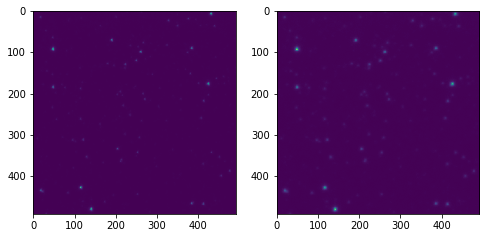

99 69124431872.0
199 53610745856.0
299 50472214528.0
399 49306025984.0
--- Finished in 5.098603248596191 seconds ---


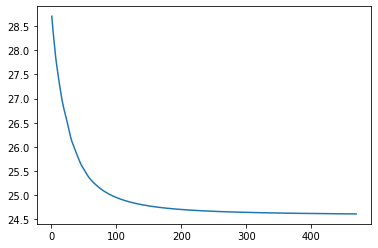

sky: [-68.265976]
kernel_sum 1.015602


In [22]:
import os

path = '/content/drive/My Drive'
#R = os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-18_00008.stack.fits')
#I = os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-19_00000.stack.fits')

R = os.path.join(path, 'coll_LOB190560Z_Llr_2019-05-14_00129.fits')
I = os.path.join(path, 'coll_LOB190560Z_Llr_2019-05-10_00107.fits')

#R = os.path.join(path, 'lsc1m005-fl15-20170725-0100-e91.fits')
#I = os.path.join(path, 'lsc1m005-fa15-20190416-0242-e91.fits')



R = getdata(R, 0, header=True)[0]
I = getdata(I, 0, header=True)[0]
R = R[crop:R.shape[0]-crop, crop:R.shape[1]-crop]
I = I[crop:I.shape[0]-crop, crop:I.shape[1]-crop]

# Display initialisation and input image
plt.figure(figsize=(5,5))
f, axarr = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(8)
axarr[0].imshow(R)
axarr[1].imshow(I)
plt.show()

# sky subtract images
R -= np.median(R)
I -= np.median(I)

# Pad reference
R = np.pad(R, pad_width=pw, mode='constant', constant_values=0)

# Convert numpy arrays to torch tensors
R, I = convert_to_tensor(R), convert_to_tensor(I)

# Move to GPU
R = R.to(device)
I = I.to(device)

kernel, sky = infer_kernel(R, I, maxiter=1000)
#kernel, sky = infer_kernel(R, I, maxiter=15)

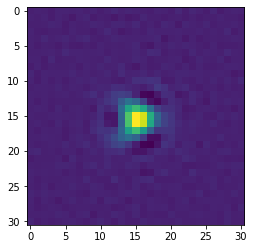

"\nfrom astropy.io import fits\n\nhdu = fits.PrimaryHDU(kernel)\nhdul = fits.HDUList([hdu])\nhdul.writeto(os.path.join(path, 'kernel_correct.fits'))\n"

In [23]:

# Flip kernel before passing to convolve2d()
kernel = np.flip(np.flip(kernel, 0), 1)
plt.imshow(kernel)
plt.show()
'''
from astropy.io import fits

hdu = fits.PrimaryHDU(kernel)
hdul = fits.HDUList([hdu])
hdul.writeto(os.path.join(path, 'kernel_correct.fits'))
'''

In [24]:
from scipy.signal import convolve2d

R = R[0][0].cpu().detach().numpy()
print(R.shape[1])
R = R[pw:R.shape[0]-pw, pw:R.shape[1]-pw]
I = I[0][0].cpu().detach().numpy()

522


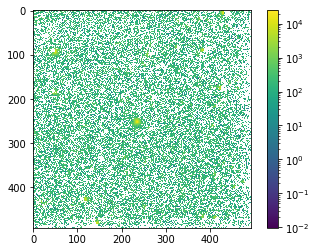

In [25]:
from matplotlib.colors import LogNorm
M = convolve2d(R, kernel, mode='same')
D = M - I + sky
plt.imshow(D, norm=LogNorm())
plt.colorbar()

In [0]:
from astropy.io import fits

hdu = fits.PrimaryHDU(D)
hdul = fits.HDUList([hdu])
hdul.writeto(os.path.join(path, 'subtraction_correct2.fits'))